Script to compute and plot maps of multi-year mean annual precipitation on SAFRAN moving sub-domains

In [1]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from config import *
from functions import get_data_yr_SAFR  # get_data_all_SAFR
from utils import *

In [2]:
### CST ###

reg = 'Fr'
dataset = 'SAFRAN'
ymin = 2005
ymax = 2006
years = np.arange(ymin, ymax+1, 1)
per = str(ymin) + '-' + str(ymax)
sizes = [10, 20, 30, 40, 50, 60]   # domain side length (number of pixels)
prop = 0.33  # proportion du côté de la fenêtre sans recouvrement (dans les deux directions)
th_n = 0.75  # minimum proportion of land grid cell for the sub-domain to be considered

projmap = ccrs.LambertConformal(central_longitude=2.337229, central_latitude=46.8, false_easting=600000., false_northing=2200000.)
resol = '50m'  # use data at this scale
bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)

In [3]:
#~ OUTDIR

if not os.path.isdir(FIGDIR + '/for_article'):
    os.mkdir(FIGDIR + '/for_article')
figdir = FIGDIR + '/for_article'

In [4]:
# Get France polygon and reprojectin SAFRAN CRS
cnydbffile = SHAPEDIR + '/world-boundaries/world-administrative-boundaries.dbf'
dfcny = gpd.read_file(cnydbffile)
dffra = gpd.GeoSeries(dfcny.iloc[93]['geometry'])
dffra.set_crs(dfcny.crs, inplace=True)
dffra_reproj = dffra.to_crs(proj)

In [5]:
# Get data
ds = get_data_yr_SAFR(1960)  # get_data_all_SAFR(ymin, ymax)


>>> 80x80 <<<
868 valid coordinates

>>> 160x160 <<<
142 valid coordinates

>>> 240x240 <<<
61 valid coordinates

>>> 320x320 <<<
33 valid coordinates

>>> 400x400 <<<
17 valid coordinates

>>> 480x480 <<<
9 valid coordinates


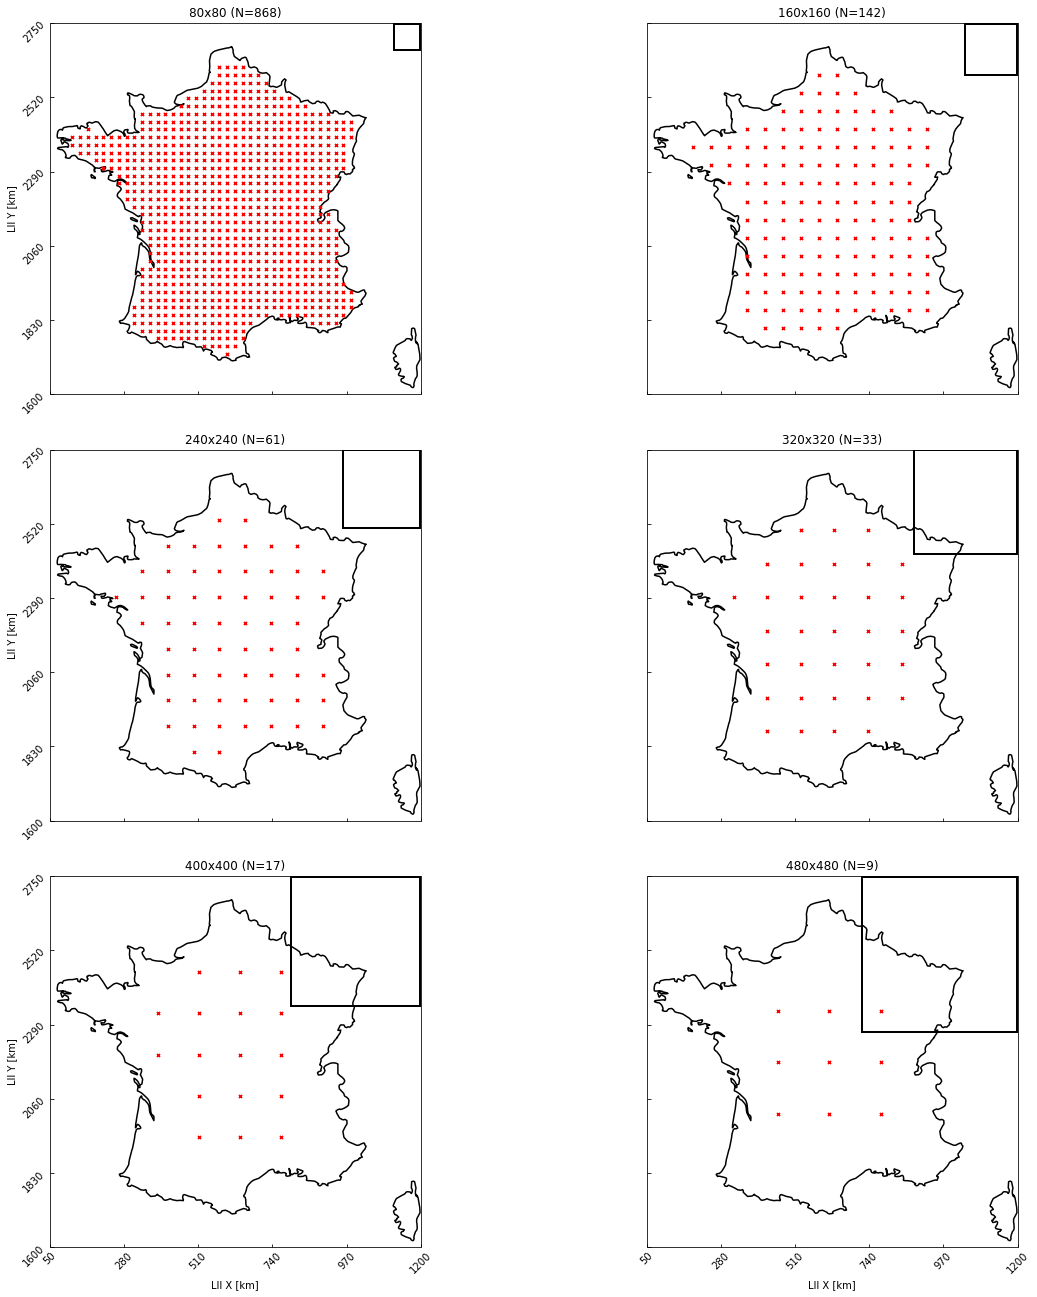

In [6]:
# Plot

xlims = (50000., 1200000.)
ylims = (1600000., 2750000.)
xtcks = np.linspace(xlims[0], xlims[1], 6)
ytcks = np.linspace(ylims[0], ylims[1], 6)
xtlbs = [int(xt/1000) for xt in xtcks]
ytlbs = [int(yt/1000) for yt in ytcks]


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20., 20.), subplot_kw={'projection': projmap})

plt.subplots_adjust(bottom=0.1, top=0.95, wspace=0.15, hspace=0.15)

i=0
j=0

for size in sizes:
    size_ = str(int(size*res/1000)) + 'x' + str(int(size*res/1000))
    print('\n>>> {0} <<<'.format(size_))

    step = int(round(size * prop, 0))  # décalage dans la sélection des coordonnées des sous-fenêtres
    ntot = size **2  # total number of pixel within domain

    if j==ax.shape[1]:
        j=0
        i=i+1

    #print(i, j, end=' : ', flush=True)

    ax_ = ax[i][j]

    # Min and max coordinates (x, y) of the lower left pixel of sub-domains
    x_min_ = x_min
    x_max_ = x_max - size * res - res
    y_min_ = y_min
    y_max_ = y_max - size * res - res
    (x_min_, y_min_), (x_max_, y_max_)

    # Coordinates of the lower left pixel of all sub-domains
    xs = pd.Series(np.arange(x_min_, x_max_+res, res))  # all x coordinates
    ys = pd.Series(np.arange(y_min_, y_max_+res, res))  # all y coordinates

    # Sub-sample sub-domains coordinates (-> over-lapping)
    xs_ = xs[::step]
    ys_ = ys[::step]

    # Get all sub-domains lower left (ll) coordinates (x, y)
    ll_cells = []
    for x in xs_:
        for y in ys_:
            ll_cells.append((x, y))
            
    coords = []

    # Get valid boxes only
    for k, ll_cell in enumerate(ll_cells):
        #print('{0}/{1}'.format((k+1), len(ll_cells)), end=' : ', flush=True)

        x_min_ = ll_cell[0]
        x_max_ = x_min_ + size * res - res
        y_min_ = ll_cell[1]
        y_max_ = y_min_ + size * res - res
        data = ds.sel(x=slice(x_min_, x_max_), y=slice(y_min_, y_max_))
        cum = data.mean(dim='time').product * len(data.indexes['time']) / len(years)

        if len(cum.values[~np.isnan(cum.values)]) >= ntot*th_n:
            coords.append((x_min_, y_min_))

    print('{0} valid coordinates'.format(len(coords)))

    # Plot centers
    for coord in coords:
        x_center = coord[0] + size * res / 2 - res / 2
        y_center = coord[1] + size * res / 2 - res / 2
        #center = '({0},{1})'.format(int(round(x_center/1000, 0)), int(round(y_center/1000, 0)))

        ax_.scatter(x_center, y_center, s=10, c='r', marker='x', zorder=100)

    #rec = Rectangle((xlims[1]-(size*0.75*res)-3*res, ylims[1]-(size*0.75*res)-3*res), size*res, size*res, color='k', fill=False, lw=2.)
    rec = Rectangle((xlims[1]-(size*res)-0.25*res, ylims[1]-(size*res)-0.25*res), size*res, size*res, color='k', fill=False, lw=2.)
    ax_.add_patch(rec)

    dffra_reproj.boundary.plot(ax=ax_, color='k')

    ax_.set_xticks(xtcks)
    ax_.set_yticks(ytcks)
    ax_.tick_params(axis='x', direction='in')
    ax_.tick_params(axis='y', direction='in')

    if j == 0:
        ax_.set_yticklabels(ytlbs, rotation=45)
        ax_.set_ylabel('LII Y [km]')
    else:
        ax_.set_yticklabels([])
    if i == ax.shape[0]-1:
        ax_.set_xticklabels(xtlbs, rotation=45)
        ax_.set_xlabel('LII X [km]')
    else:
        ax_.set_xticklabels([])

    ax_.set_xlim(xlims)
    ax_.set_ylim(ylims)

    ax_.set_title(size_ + ' (N=%i)'% len(coords))
    j=j+1

    #sys.exit()

#~ Save

figfile = figdir + '/fig1.png'

fig.savefig(figfile, dpi=300)

In [18]:
fig.savefig(figfile, dpi=400)